# Import the Libraries that needed

In [ ]:
# Cell 1: Import
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori

# Do the preprocessing data

In [ ]:
print("\nMissing values:", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values: Unnamed: 0                  0
Kehamilan                   0
Glukosa                     0
Tekanan Darah               0
Ketebalan Kulit             0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Umur                        0
Hasil                       0
Kategori_Glukosa            0
Kategori_BMI                0
Kategori_Umur               0
Status_Diabetes             0
Glukosa_Status              0
BMI_Status                  0
Umur_Status                 0
dtype: int64

Duplicate rows: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Cell 2: Load dan preprocessing data
df = pd.read_csv('diabetes.csv')

# Categorizing the data and encode with labels mapping
df['Kategori_Glukosa'] = pd.qcut(df['Glukosa'], q=2, labels=['Normal', 'Tinggi'])
df['Kategori_BMI'] = pd.qcut(df['BMI'], q=2, labels=['Normal', 'Tinggi'])
df['Kategori_Umur'] = pd.qcut(df['Umur'], q=2, labels=['Muda', 'Tua'])

#create new variable to see the relationship
df['Status_Diabetes'] = df['Hasil'].map({0: 'Non-Diabetes', 1: 'Diabetes'})

# Convert to the string
df['Kategori_Glukosa'] = df['Kategori_Glukosa'].astype(str)
df['Kategori_BMI'] = df['Kategori_BMI'].astype(str)
df['Kategori_Umur'] = df['Kategori_Umur'].astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Merge the cell to craete new informative feature

In [ ]:
# Cell 3: Combine with the relevan feature
df['Glukosa_Status'] = df['Kategori_Glukosa'] + '_' + df['Status_Diabetes']
df['BMI_Status'] = df['Kategori_BMI'] + '_' + df['Status_Diabetes']
df['Umur_Status'] = df['Kategori_Umur'] + '_' + df['Status_Diabetes']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Encode the columns into numerical data

In [ ]:
# Cell 4: Encoding
df_encoded = pd.get_dummies(df[['Glukosa_Status', 'BMI_Status', 'Umur_Status',
                               'Kategori_Glukosa', 'Kategori_BMI',
                               'Kategori_Umur', 'Status_Diabetes']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define minimum support

In [ ]:
# Cell 5: Generate frequent itemsets dengan support lebih tinggi
frequent_itemsets = apriori(df_encoded, min_support=0.4, use_colnames=True)
print("Frequent patterns found:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

Frequent patterns found:
     support                                           itemsets
8   0.651042                     (Status_Diabetes_Non-Diabetes)
6   0.515625                               (Kategori_Umur_Muda)
2   0.509115                          (Kategori_Glukosa_Normal)
4   0.502604                              (Kategori_BMI_Normal)
5   0.497396                              (Kategori_BMI_Tinggi)
3   0.490885                          (Kategori_Glukosa_Tinggi)
7   0.484375                                (Kategori_Umur_Tua)
10  0.425781  (Status_Diabetes_Non-Diabetes, Glukosa_Status_...
15  0.425781  (Kategori_Glukosa_Normal, Status_Diabetes_Non-...
13  0.425781  (Kategori_Glukosa_Normal, Status_Diabetes_Non-...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define the minimum confidence

In [ ]:
# Cell 6: Generate rules with the high confidence
def generate_rules(frequent_itemsets, min_confidence=0.85):
    rules = []

    for _, row in frequent_itemsets.iterrows():
        items = row['itemsets']
        support = row['support']


      # Check the itemset that appear frequently
        if len(items) > 1:
            for item in items:
                antecedent = frozenset([item])
                consequent = items - antecedent

      # Check if there is any consequent (then)
                if len(consequent) > 0:
                    conf = support / frequent_itemsets[
                        frequent_itemsets['itemsets'] == antecedent
                    ]['support'].iloc[0]

                    if conf >= min_confidence:
                        lift = conf / (frequent_itemsets[
                            frequent_itemsets['itemsets'] == consequent
                        ]['support'].iloc[0])

      # Generate the rules
                        rules.append({
                            'antecedent': antecedent,
                            'consequent': consequent,
                            'support': support,
                            'confidence': conf,
                            'lift': lift
                        })

    return pd.DataFrame(rules)

rules = generate_rules(frequent_itemsets)
rules = rules.sort_values(['confidence', 'support'], ascending=[False, False])

print("\nTop Association Rules (Confidence >= 85%, Support >= 40%):")
for idx, row in rules.head(10).iterrows():
    print(f"\nIf {list(row['antecedent'])} Then {list(row['consequent'])}")
    print(f"Confidence: {row['confidence']:.2f}")
    print(f"Support: {row['support']:.2f}")
    print(f"Lift: {row['lift']:.2f}")


Top Association Rules (Confidence >= 85%, Support >= 40%):

If ['Glukosa_Status_Normal_Non-Diabetes'] Then ['Kategori_Glukosa_Normal']
Confidence: 1.00
Support: 0.43
Lift: 1.96

If ['Glukosa_Status_Normal_Non-Diabetes'] Then ['Status_Diabetes_Non-Diabetes']
Confidence: 1.00
Support: 0.43
Lift: 1.54

If ['Glukosa_Status_Normal_Non-Diabetes'] Then ['Kategori_Glukosa_Normal', 'Status_Diabetes_Non-Diabetes']
Confidence: 1.00
Support: 0.43
Lift: 2.35

If ['Umur_Status_Muda_Non-Diabetes'] Then ['Kategori_Umur_Muda']
Confidence: 1.00
Support: 0.41
Lift: 1.94

If ['Umur_Status_Muda_Non-Diabetes'] Then ['Status_Diabetes_Non-Diabetes']
Confidence: 1.00
Support: 0.41
Lift: 1.54

If ['Umur_Status_Muda_Non-Diabetes'] Then ['Status_Diabetes_Non-Diabetes', 'Kategori_Umur_Muda']
Confidence: 1.00
Support: 0.41
Lift: 2.46


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualizing the result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


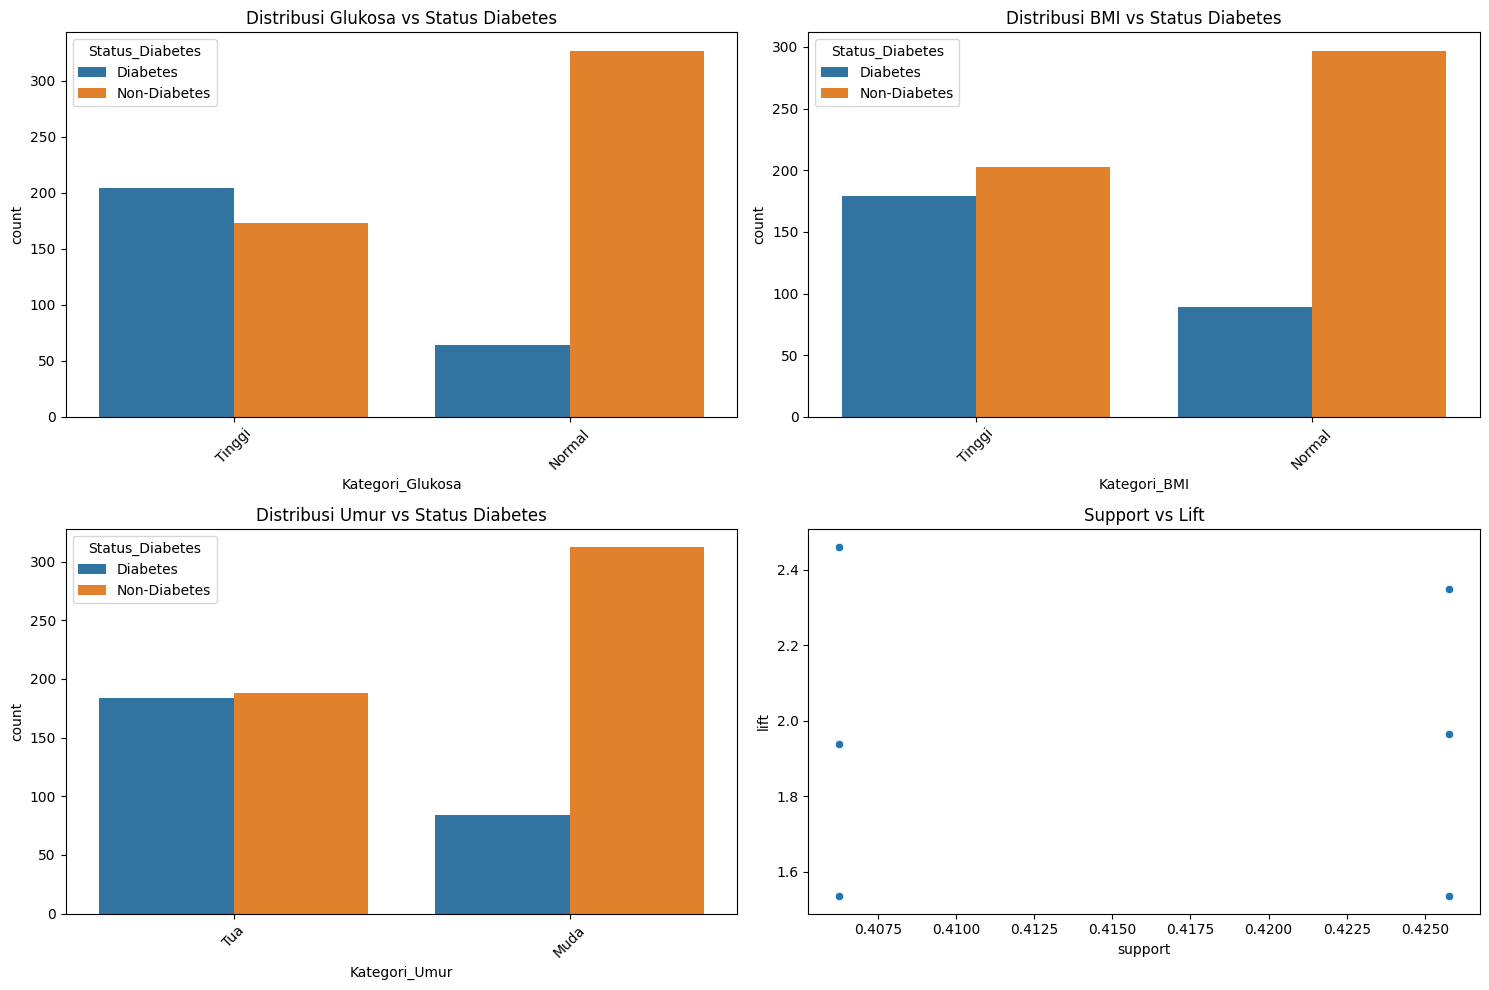

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 7: Visualisasi distribusi berdasarkan kategori
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot distribusi per kategori
sns.countplot(data=df, x='Kategori_Glukosa', hue='Status_Diabetes', ax=axes[0,0])
axes[0,0].set_title('Distribusi Glukosa vs Status Diabetes')
axes[0,0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Kategori_BMI', hue='Status_Diabetes', ax=axes[0,1])
axes[0,1].set_title('Distribusi BMI vs Status Diabetes')
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Kategori_Umur', hue='Status_Diabetes', ax=axes[1,0])
axes[1,0].set_title('Distribusi Umur vs Status Diabetes')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot support vs lift
sns.scatterplot(data=rules, x='support', y='lift', ax=axes[1,1])
axes[1,1].set_title('Support vs Lift')

plt.tight_layout()
plt.show()